# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figure8_sdv.ipynb` from `6_sdv_...`
### Including only the code required to make figure svd, from notebook `6_sdv_steven_edits.ipynb`

created by Cassie Lumbrazo\
last updated: June 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

---

In [3]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [4]:
# Constants 
# define path to save the figures to
# figure_path = "C:\\Users\\Lumbr\\OneDrive - UW\\Documents - mountainhydro\\People\\CassieLumbrazo\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\" # Cassie local path
# figure_path = 'C:\\Users\\Lumbr\\OneDrive - University of Alaska\\UW_OneDrive\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\' # Cassie remote path
# figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'black'
colortreatment = 'saddlebrown'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

In [5]:
from scipy.stats.mstats import mquantiles

def cdf(x):
    x = x[~np.isnan(x)]
    q = np.arange(0,1,0.01)
    y = mquantiles(x, q)
    return (y, q)

Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [6]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [7]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

In [8]:
# print the mean and standard deviations used to calculate 
print('Mean HS RAPID:', ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y']).values)
print('Mean HS NCALM:', ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y']).values)
print('STD HS RAPID:', ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y']).values)
print('STD HS NCALM:', ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y']).values)

Mean HS RAPID: [0.39387816]
Mean HS NCALM: [0.33291218]
STD HS RAPID: [0.22906527]
STD HS NCALM: [0.28451866]


In [9]:
# print the median values 
print(f'median south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median().values)
print(f'median north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median().values)

median south:  0.108297125
median north:  0.12858474


Now, just look at treatment and control across the ridge, 

In [10]:
ds['sdv_diff_treatment'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

In [11]:
# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'
colortreatment2 = 'darkslategrey'

In [12]:
# print the medians from the plot 
print(f'median treatment: ', ds['sdv_diff_treatment'].median().values)
print(f'median control: ', ds['sdv_diff_control'].median().values)

median treatment:  0.15693569
median control:  -0.0140082985


Now, north and south by treated and untreated areas

In [13]:
ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

In [14]:
# print the medians 
print(f'median control south: ', ds['sdv_diff_control_south'].median().values)
print(f'median treatment south: ', ds['sdv_diff_treatment_south'].median().values)
print(f'median control north: ', ds['sdv_diff_control_north'].median().values)
print(f'median treatment north: ', ds['sdv_diff_treatment_north'].median().values)

median control south:  0.14517897
median treatment south:  0.096662045
median control north:  -0.27967072
median treatment north:  0.262797


# Figure SVD

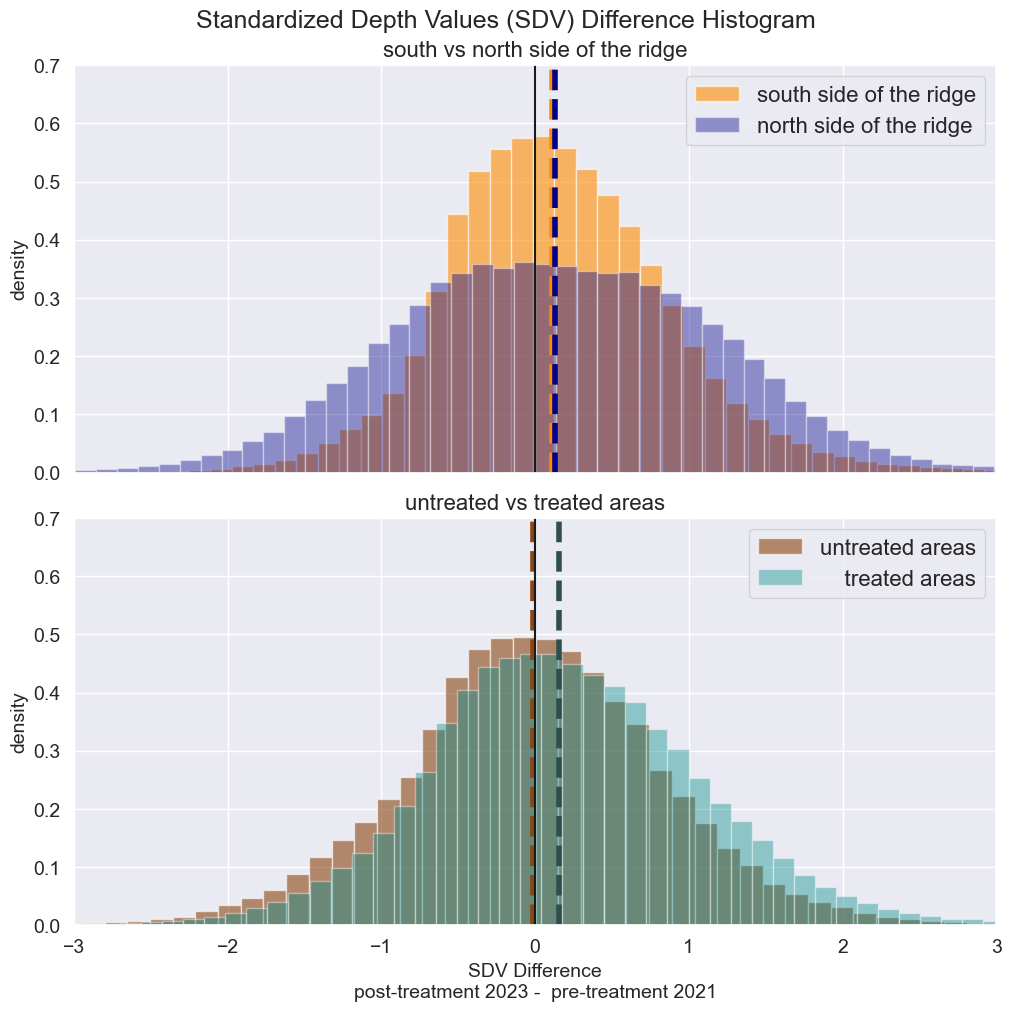

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)

ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.6, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.4, density=True, label='north side of the ridge');
ds['sdv_diff_control'].plot.hist(  ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=4, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_control'].median(), color=colorcontrol, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_treatment'].median(), color=colortreatment2, linestyle='dashed', linewidth=4, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 16)
axes[1].legend(fontsize = 16)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 14)
axes[1].set_ylabel('density', fontsize = 14)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=14)

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram', fontsize=18)

axes[0].set_title('south vs north side of the ridge', fontsize = 16)
axes[1].set_title('untreated vs treated areas', fontsize = 16)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# export the figure with high resolution
figure_name = 'figure8_sdv_left.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

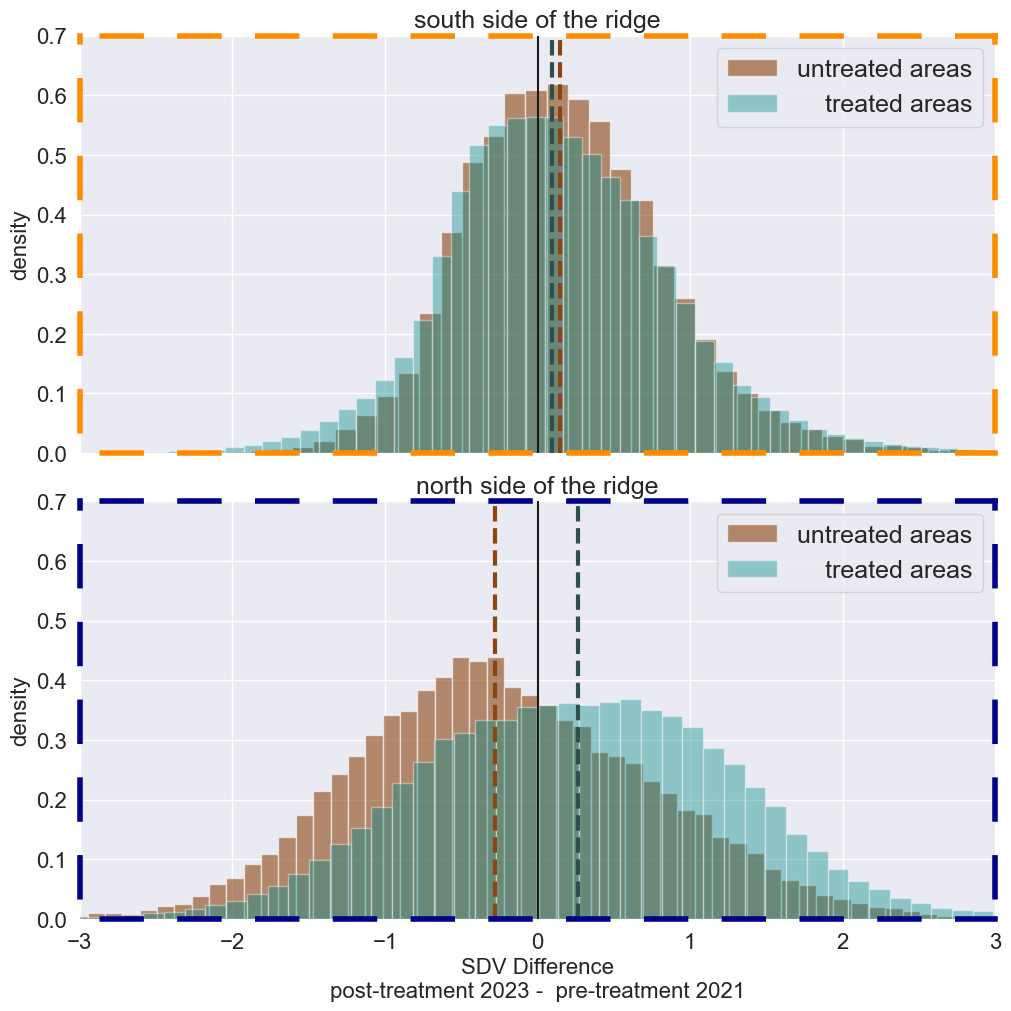

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
ds['sdv_diff_control_south'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_south'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_north'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 18)
axes[1].legend(fontsize = 18)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 16)
axes[1].set_ylabel('density', fontsize = 16)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=16)

# plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')

axes[0].set_title('south side of the ridge', fontsize = 18)
axes[1].set_title('north side of the ridge', fontsize = 18)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# make an orange outline on the first subplot 
for spine in axes[0].spines.values():
    spine.set_edgecolor(colorsouth)
    spine.set_linewidth(4)
    # spine.set_linestyle('dashed')
    spine.set_linestyle((10, (7,7))) # line width, then (points, gap)
    
# make a blue outline on the second subplot
for spine in axes[1].spines.values():
    spine.set_edgecolor(colornorth)
    spine.set_linewidth(4)
    spine.set_linestyle((10, (7,7)))
    
# # add a C) and D) to the subplots 
# axes[0].text(0.01, 0.9, 'C)', fontsize=18, transform=axes[0].transAxes)
# axes[1].text(0.01, 0.9, 'D)', fontsize=18, transform=axes[1].transAxes)

# export the figure with high resolution
figure_name = 'figure8_sdv_right.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

## Print the median and standard deviations for all the groups

In [17]:
# print the mean and standard deviation for all the groups plotted above 
print(f'mean south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).mean().values)
print(f'mean north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).mean().values)
print(f'mean control: ', ds['sdv_diff_control'].mean().values)
print(f'mean treatment: ', ds['sdv_diff_treatment'].mean().values)

print(f'std south: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).std().values)
print(f'std north: ', ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).std().values)
print(f'std control: ', ds['sdv_diff_control'].std().values)
print(f'std treatment: ', ds['sdv_diff_treatment'].std().values)

# print the mean and standard deviation for the south and north side of the ridge
print(f'mean control south: ', ds['sdv_diff_control_south'].mean().values)
print(f'mean treatment south: ', ds['sdv_diff_treatment_south'].mean().values)
print(f'mean control north: ', ds['sdv_diff_control_north'].mean().values)
print(f'mean treatment north: ', ds['sdv_diff_treatment_north'].mean().values)

print(f'std control south: ', ds['sdv_diff_control_south'].std().values)
print(f'std treatment south: ', ds['sdv_diff_treatment_south'].std().values)
print(f'std control north: ', ds['sdv_diff_control_north'].std().values)
print(f'std treatment north: ', ds['sdv_diff_treatment_north'].std().values)

mean south:  0.16131082
mean north:  0.14479516
mean control:  -1.9712152e-08
mean treatment:  0.19993336
std south:  0.76777524
std north:  1.037863
std control:  0.8912795
std treatment:  0.9053451
mean control south:  0.20415075
mean treatment south:  0.14862332
mean control north:  -0.21836677
mean treatment north:  0.25738704
std control south:  0.72613925
std treatment south:  0.7792277
std control north:  0.9938893
std treatment north:  1.0253259
